In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/room-occupancy-detection-data-iot-sensor/Occupancy.csv


In [2]:
import pandas as pd
df =pd.read_csv('/kaggle/input/room-occupancy-detection-data-iot-sensor/Occupancy.csv')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [5]:
df.describe()
#Occupancy : need to check the imbalance between 0 and 1

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_20/286883234.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


<Axes: >

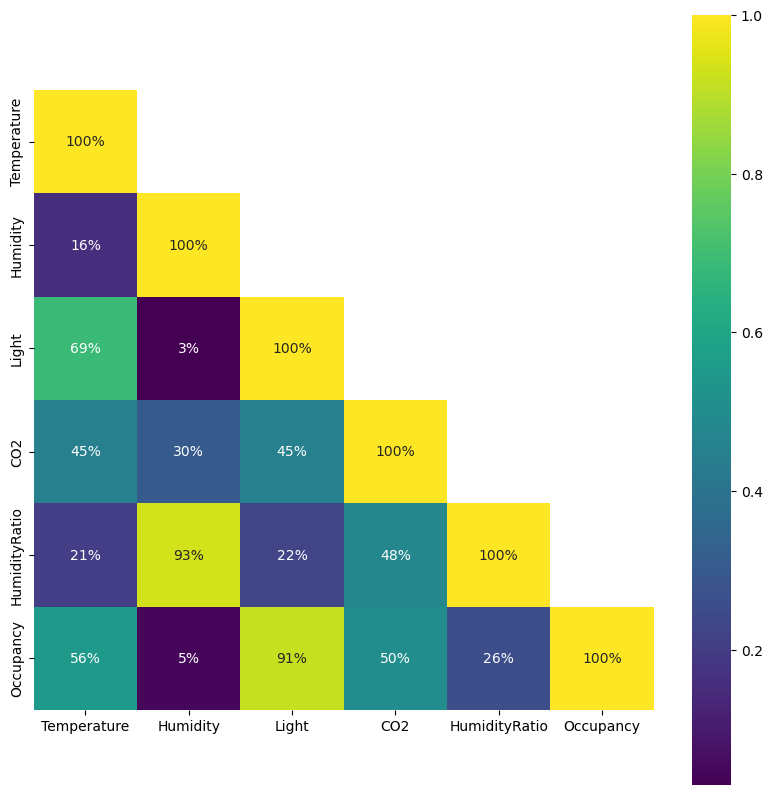

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,10))

corr_matrix = df.corr().abs()
up_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)

sns.heatmap(corr_matrix, mask=up_mask, annot=True, fmt='.0%', square=True, cmap='viridis')

#Strong correlation between 'Light' and 'Occupancy' / 'HumidityRatio' and 'Humidity'

In [7]:
df.Occupancy.value_counts()
#it might be necessary to oversample data

0    15810
1     4750
Name: Occupancy, dtype: int64

<Axes: >

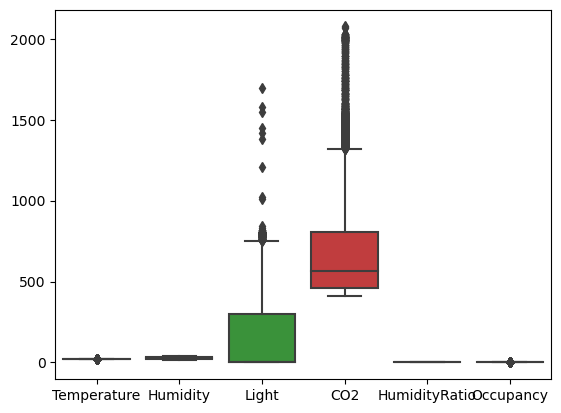

In [8]:
sns.boxplot(df)
#many outliers from 'Light' and 'CO2'

<Axes: xlabel='Light', ylabel='Count'>

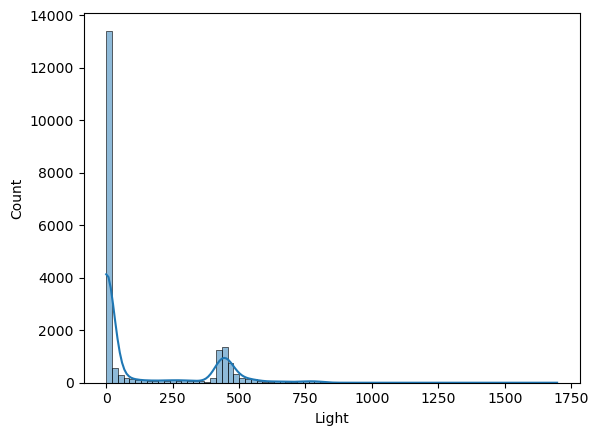

In [9]:
#Light's distribution
sns.histplot(df.Light, kde=True)

In [10]:
len(df[df.Light != 0])

7788

<Axes: xlabel='CO2', ylabel='Count'>

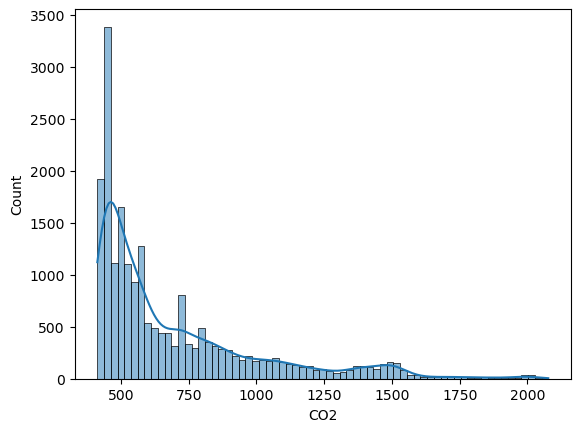

In [11]:
#CO2 : seems to be the log distribution
sns.histplot(df.CO2, kde=True)

### Preprocessing data

In [12]:
#1. remove 'HumidityRatio' and 'date'
df.drop(columns = 'HumidityRatio', inplace=True)
df.drop(columns = 'date', inplace=True)

In [13]:
#2. CO2 log transformation
df['CO2_log'] = np.log1p(df.CO2)

<Axes: xlabel='CO2_log', ylabel='Count'>

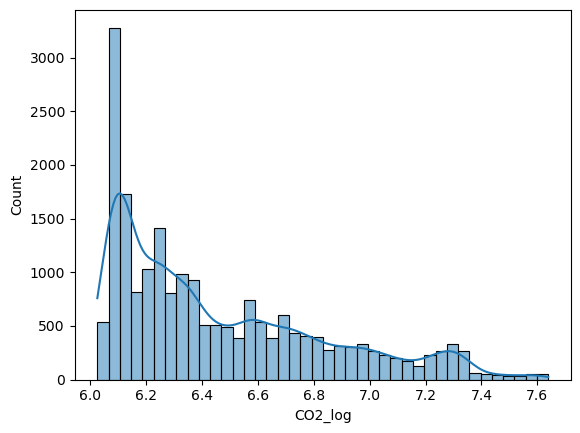

In [14]:
sns.histplot(df.CO2_log, kde=True)

<Axes: xlabel='Light'>

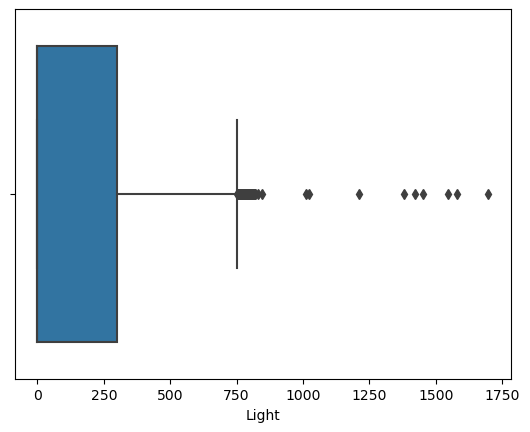

In [15]:
#3. Do we have to remove the outliers of 'Light'?
#'Light' has high correlation with the dependent variable, 'Occupancy'
#dangerous to remove all the outliers
sns.boxplot(x='Light', data = df)

In [16]:
#Suggest new variable which is 1 when the light is turned on, 0 else
df['Light_new'] = df.Light.apply(lambda x : 1 if x > 0 else 0)

In [17]:
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,CO2_log,Light_new
0,23.7000,26.272,585.200000,749.200000,1,6.620340,1
1,23.7180,26.290,578.400000,760.400000,1,6.635159,1
2,23.7300,26.230,572.666667,769.666667,1,6.647256,1
3,23.7225,26.125,493.750000,774.750000,1,6.653830,1
4,23.7540,26.200,488.600000,779.000000,1,6.659294,1


### Oversampling

In [18]:
from sklearn.model_selection import train_test_split

X_original  =df.drop(columns=['Occupancy','CO2','Light_new'])
X_new = df.drop(columns = ['Occupancy','CO2','Light'])
y =df['Occupancy']

X_train_org , X_test_org , y_train_org, y_test_org  = train_test_split(X_original,y,stratify=y,random_state=1,test_size=0.3)
X_train_new , X_test_new , y_train_new, y_test_new  = train_test_split(X_new,y,stratify=y,random_state=1,test_size=0.3)

In [19]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.preprocessing import StandardScaler

X_imb_org  = X_train_org.reset_index(drop=True).copy()
y_imb_org  = y_train_org.reset_index(drop=True).copy()

X_imb_new  = X_train_new.reset_index(drop=True).copy()
y_imb_new  = y_train_new.reset_index(drop=True).copy()

In [20]:
#Random Oversampling
X_samp_org, y_samp_org = RandomOverSampler(random_state=1).fit_resample(X_imb_org,y_imb_org)
samp_org = pd.concat([X_samp_org,y_samp_org],axis=1)

X_samp_new, y_samp_new = RandomOverSampler(random_state=1).fit_resample(X_imb_new,y_imb_new)
samp_new = pd.concat([X_samp_new,y_samp_new],axis=1)

In [21]:
#SMOTE
X_smote_org, y_smote_org = SMOTE(random_state=1).fit_resample(X_imb_org,y_imb_org)
smote_org = pd.concat([X_smote_org, y_smote_org],axis=1)

X_smote_new, y_smote_new = SMOTE(random_state=1).fit_resample(X_imb_new,y_imb_new)
smote_new = pd.concat([X_smote_new, y_smote_new],axis=1)

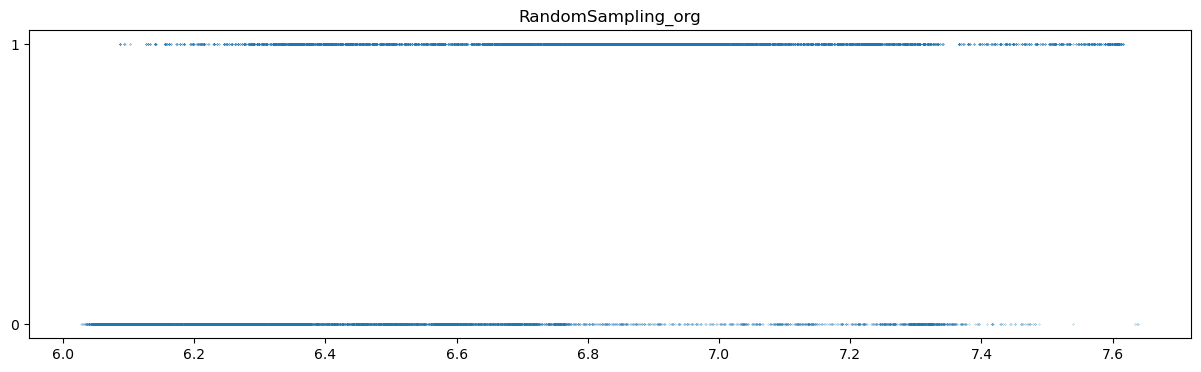

In [22]:
plt.figure(figsize=(15,4))
plt.title('RandomSampling_org')
plt.scatter(samp_org['CO2_log'],samp_org['Occupancy'].astype('str'),s=0.03)

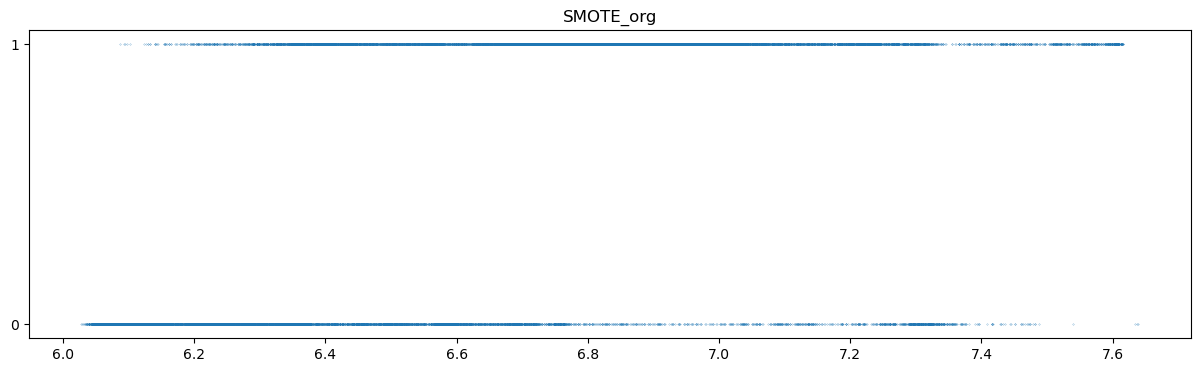

In [23]:
plt.figure(figsize=(15,4))
plt.title('SMOTE_org')
plt.scatter(smote_org['CO2_log'],smote_org['Occupancy'].astype('str'),s=0.03)

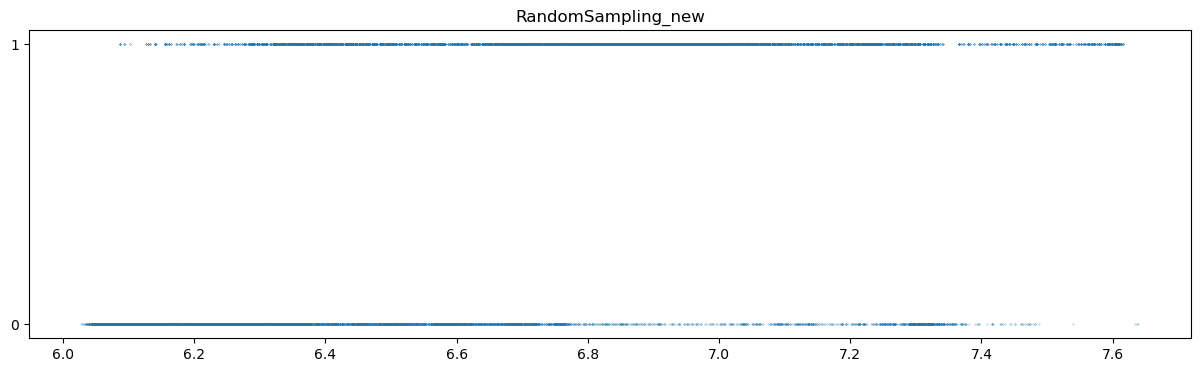

In [24]:
plt.figure(figsize=(15,4))
plt.title('RandomSampling_new')
plt.scatter(samp_new['CO2_log'],samp_new['Occupancy'].astype('str'),s=0.03)

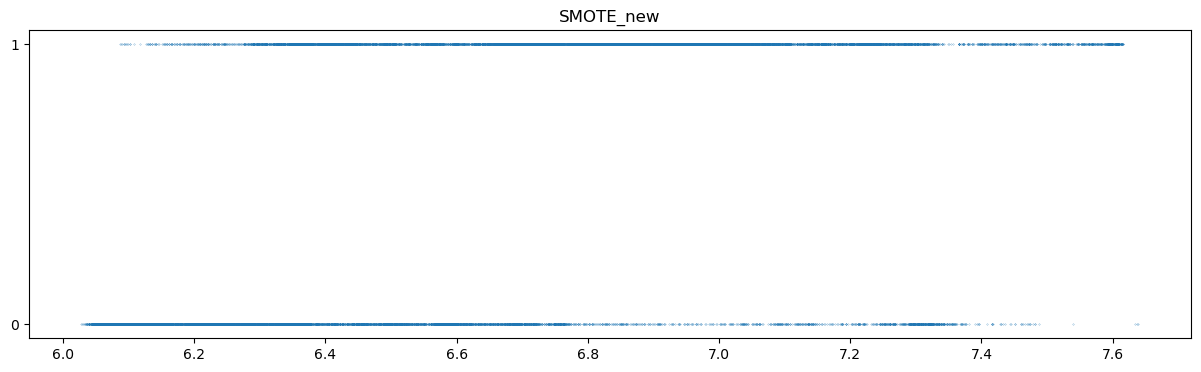

In [25]:
plt.figure(figsize=(15,4))
plt.title('SMOTE_new')
plt.scatter(smote_new['CO2_log'],smote_new['Occupancy'].astype('str'),s=0.03)

### Modeling
 - Logistic Regression & LightGBM

In [26]:
def label_mapping(x) :
    if x == 1 :
        return 0
    elif x== -1 :
        return 1
    else :
        return x

#Evaluation Function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def evaluate_model(model, train_x, train_y, test_x, test_y):
    
    x_train_copy = train_x.copy()
    y_train_copy = train_y.copy()
    x_test_copy = test_x.copy()
    y_test_copy = test_y.copy()
    
    start = time.time()
    model.fit(x_train_copy, y_train_copy)
    end = time.time() - start
    
    pred = model.predict(x_test_copy)
    
    from sklearn.ensemble import IsolationForest
    if isinstance(model, IsolationForest) :
        pred = np.array(list(map(label_mapping, pred)))

    # calculate metrics
    accuracy_test = accuracy_score(y_test_copy, pred)
    precision_test= precision_score(y_test_copy, pred)
    recall_test = recall_score(y_test_copy, pred)
    f1_test = f1_score(y_test_copy, pred)
    auc_test = roc_auc_score(y_test_copy, pred)
    
    rt_tuple = np.array([accuracy_test, precision_test, recall_test, \
                f1_test, auc_test, end])
    rt_arr = np.array(rt_tuple).reshape(1, -1)
#     rt_arr = rt_tuple
    return pd.DataFrame(rt_arr, columns=['accuracy', 'precision', 'recall' \
                                        , 'f1', 'auc', 'time'])

In [27]:
#Scaling
from sklearn.preprocessing import StandardScaler
ss_org = StandardScaler()
ss_new = StandardScaler()
ss_samp_org = StandardScaler()
ss_samp_new = StandardScaler()
ss_smote_org = StandardScaler()
ss_smote_new = StandardScaler()

#X_train에 대하여 scaler적용
X_imb_org_ss = ss_org.fit_transform(X_imb_org)
X_test_org_ss = ss_org.transform(X_test_org)

X_imb_new_ss = ss_new.fit_transform(X_imb_new)
X_test_new_ss = ss_new.transform(X_test_new)

X_samp_org_ss = ss_samp_org.fit_transform(X_samp_org)
X_test_samp_org_ss = ss_samp_org.transform(X_test_org)

X_samp_new_ss = ss_samp_new.fit_transform(X_samp_new)
X_test_samp_new_ss = ss_samp_new.transform(X_test_new)

X_smote_org_ss = ss_smote_org.fit_transform(X_smote_org)
X_test_smote_org_ss = ss_smote_org.transform(X_test_org)

X_smote_new_ss = ss_smote_new.fit_transform(X_smote_new)
X_test_smote_new_ss = ss_smote_new.transform(X_test_new)

In [28]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

lr = LogisticRegression(random_state=1)
lgbm = LGBMClassifier(random_state=1)

# LR 
lr_org = evaluate_model(lr, X_imb_org_ss, y_imb_org, X_test_org_ss, y_test_org)
lr_samp = evaluate_model(lr, X_samp_org_ss, y_samp_org, X_test_samp_org_ss, y_test_org)
lr_smote = evaluate_model(lr, X_smote_org_ss, y_smote_org, X_test_smote_org_ss, y_test_org)

lr_org_new = evaluate_model(lr, X_imb_new_ss, y_imb_new, X_test_new_ss, y_test_new)
lr_samp_new = evaluate_model(lr, X_samp_new_ss, y_samp_new, X_test_samp_new_ss, y_test_new)
lr_smote_new = evaluate_model(lr, X_smote_new_ss, y_smote_new, X_test_smote_new_ss, y_test_new)

# LGBM 
lgbm_org = evaluate_model(lgbm, X_imb_org_ss, y_imb_org, X_test_org_ss, y_test_org)
lgbm_samp = evaluate_model(lgbm, X_samp_org_ss, y_samp_org, X_test_samp_org_ss, y_test_org)
lgbm_smote = evaluate_model(lgbm, X_smote_org_ss, y_smote_org, X_test_smote_org_ss, y_test_org)

lgbm_org_new = evaluate_model(lgbm, X_imb_new_ss, y_imb_new, X_test_new_ss, y_test_new)
lgbm_samp_new = evaluate_model(lgbm, X_samp_new_ss, y_samp_new, X_test_samp_new_ss, y_test_new)
lgbm_smote_new = evaluate_model(lgbm, X_smote_new_ss, y_smote_new, X_test_smote_new_ss, y_test_new)

In [29]:
df_result = pd.concat([lr_org, lr_samp, lr_smote, lr_org_new, lr_samp_new, lr_smote_new,
                      lgbm_org, lgbm_samp, lgbm_smote, lgbm_org_new, lgbm_samp_new, lgbm_smote_new], axis=0)
df_result.index=['lr_org', 'lr_samp', 'lr_smote', 'lr_org_new', 'lr_samp_new', 'lr_smote_new',
                      'lgbm_org', 'lgbm_samp', 'lgbm_smote', 'lgbm_org_new', 'lgbm_samp_new', 'lgbm_smote_new']
display(df_result)

,accuracy,precision,recall,f1,auc,time
lr_org,0.989786,0.963265,0.993684,0.978238,0.991150,0.027122
lr_samp,0.989948,0.960784,0.997193,0.978650,0.992482,0.040542
lr_smote,0.989948,0.960784,0.997193,0.978650,0.992482,0.040595
lr_org_new,0.936446,0.880059,0.839298,0.859195,0.902466,0.045935
lr_samp_new,0.935149,0.790040,0.979649,0.874687,0.950714,0.117373
lr_smote_new,0.934825,0.790130,0.977544,0.873902,0.949767,0.067457
lgbm_org,0.993353,0.982566,0.988772,0.985659,0.991751,0.668846
lgbm_samp,0.993191,0.979875,0.990877,0.985345,0.992381,0.580499
lgbm_smote,0.993191,0.979875,0.990877,0.985345,0.992381,0.564181
lgbm_org_new,0.991732,0.977747,0.986667,0.982187,0.989960,0.534375


In terms of accuracy, lightGBM is the better choice, while LR is better when time is considered.
New model ('Light' variable changed to 0 and 1) is worse than the original among all types of models.
If 'time' is not the most important value, 'lightGBM with random oversampling' might be the best option.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

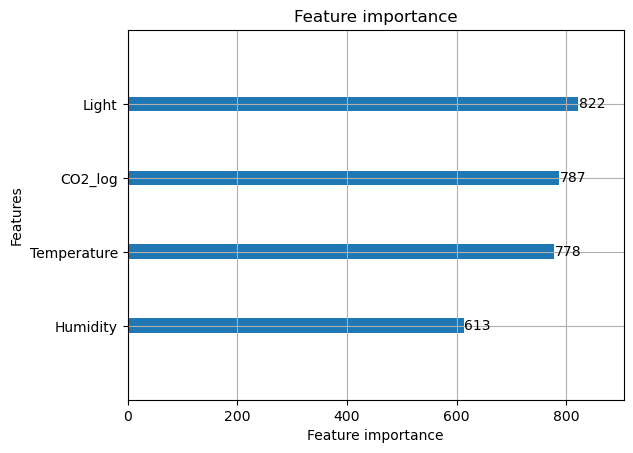

In [30]:
from lightgbm import plot_importance


X_samp_org_ss = ss_samp_org.fit_transform(X_samp_org)
X_test_samp_org_ss = ss_samp_org.transform(X_test_org)
X_samp_org_ss = pd.DataFrame(X_samp_org_ss, columns = X_samp_org.columns)
X_test_samp_org_ss = pd.DataFrame(X_test_samp_org_ss, columns = X_test_org.columns)

evaluate_model(lgbm, X_samp_org_ss, y_samp_org, X_test_samp_org_ss, y_test_org)
plot_importance(lgbm)

Already checked doing EDA, Light is the most important variable. There is not much difference between the feature importances of CO2 and Temperature.